In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from presets import OUTPUT

torch.set_printoptions(profile="full")

sample = torch.load(OUTPUT.PYTORCH_VALUES)
print(sample.shape)

torch.Size([23, 256, 256])


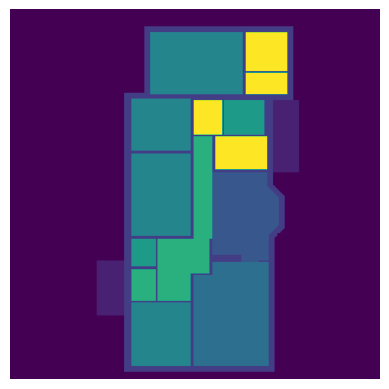

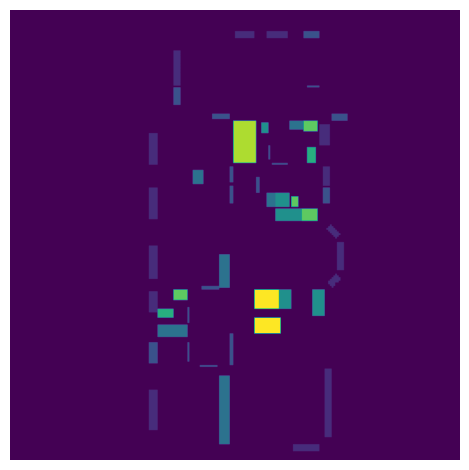

In [6]:
# Room segmentation map
plt.imshow(sample[21])
plt.axis('off') # Remove the axes
plt.show()
# plt.set_title('Room Labels')

# Icon segmentation map
plt.imshow(sample[22])
plt.axis('off')
# plt.set_title('Icon Labels')

plt.tight_layout()
plt.show()

# Heatmaps
# for i in range(21):
#     plt.imshow(sample[i])
#     plt.title(f'Heatmap {i+1}')
#     plt.axis('off')
#     plt.show()

In [7]:
import cv2
import numpy as np
from icecream import ic

# Helper function: Extract contours and fit to quadrilateral (4 points)
def extract_labeled_room_contours(segmentation_map, min_area=0):
    #room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
    unique_labels = np.unique(segmentation_map)
    room_contours = []
    room_classes = []  # Add list to store room classes
    outer_contour = None
    max_area = 12000

    for label in unique_labels:
        room_mask = (segmentation_map == label).astype(np.uint8) * 255
        contours, _ = cv2.findContours(room_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > min_area:
                epsilon = 0.01 * cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, epsilon, True)
                if area > max_area:
                    outer_contour = approx
                    outer_contour_class = label  # Store class for outer contour
                else:
                    room_contours.append(approx)
                    room_classes.append(label)  # Store class for each room

    return outer_contour, outer_contour_class, room_contours, room_classes  # Return classes along with contours

# def get_outer_floorplan_contour(segmentation_map):
#     outer_contour, _ = extract_labeled_room_contours(segmentation_map)
#     return outer_contour

def line_intersects_rectangle(line_start, line_end, rect):
    def ccw(A, B, C):
        return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

    def line_intersects(A, B, C, D):
        return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

    rect_lines = [
        (rect[0], rect[1]),
        (rect[1], rect[2]),
        (rect[2], rect[3]),
        (rect[3], rect[0])
    ]

    for rect_line in rect_lines:
        if line_intersects(line_start, line_end, rect_line[0], rect_line[1]):
            return True

    return False

def point_in_rectangle(point, rect):
    x, y = point
    return rect[0][0] <= x <= rect[2][0] and rect[0][1] <= y <= rect[2][1]

def find_intersection_point(line_start, line_end, rect):
    def line_intersection(line1, line2):
        x1, y1 = line1[0]
        x2, y2 = line1[1]
        x3, y3 = line2[0]
        x4, y4 = line2[1]
        
        den = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        if den == 0:
            return None  # Lines are parallel
        
        t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / den
        if 0 <= t <= 1:
            return (x1 + t * (x2 - x1), y1 + t * (y2 - y1))
        return None

    rect_lines = [
        (rect[0], rect[1]),
        (rect[1], rect[2]),
        (rect[2], rect[3]),
        (rect[3], rect[0])
    ]

    for rect_line in rect_lines:
        intersection = line_intersection((line_start, line_end), rect_line)
        if intersection:
            return intersection
    return None

def point_equal(p1, p2):
    return np.allclose(p1, p2)

def generate_walls(room_polygons, icon_quadrilaterals, which, wall_height=10):
    walls = []
    for i, room in enumerate(room_polygons):
        # if which == "outer" and i == 0:
        #     continue
        # elif which == "inner" and i == 10:
        #     continue
        for i in range(len(room)):
            next_i = (i + 1) % len(room)
            wall_start = room[i][0]
            wall_end = room[next_i][0]

            current_point = wall_start
            while not point_equal(current_point, wall_end):
                next_point = wall_end
                intersecting_icon = None
                intersection_point = None

                for icon in icon_quadrilaterals:
                    if line_intersects_rectangle(current_point, next_point, icon):
                        intersecting_icon = icon
                        intersection_point = find_intersection_point(current_point, next_point, icon)
                        if intersection_point is not None:
                            next_point = intersection_point
                            break

                if intersecting_icon is not None:
                    # Create wall segment up to the icon
                    wall = [
                        [current_point[0], current_point[1], 0],
                        [next_point[0], next_point[1], 0],
                        [next_point[0], next_point[1], wall_height],
                        [current_point[0], current_point[1], wall_height]
                    ]
                    walls.append(wall)

                    # Find exit point from the icon
                    exit_point = None
                    for icon_point in icon:
                        if not point_in_rectangle(icon_point, intersecting_icon) and \
                           line_intersects_rectangle(icon_point, wall_end, intersecting_icon):
                            exit_point = icon_point
                            break

                    if exit_point is not None:
                        current_point = exit_point
                    else:
                        # If no suitable exit point found, move to the next corner of the icon
                        icon_index = next((i for i, point in enumerate(icon) if point_equal(point, next_point)), None)
                        if icon_index is not None:
                            current_point = icon[(icon_index + 1) % 4]
                        else:
                            # If we can't find the next point in the icon, just move to wall_end to avoid infinite loop
                            current_point = wall_end
                else:
                    # No intersection, create full wall segment
                    wall = [
                        [current_point[0], current_point[1], 0],
                        [next_point[0], next_point[1], 0],
                        [next_point[0], next_point[1], wall_height],
                        [current_point[0], current_point[1], wall_height]
                    ]
                    walls.append(wall)
                    current_point = next_point

    return walls

# Helper function: Extract icons (doors, windows, etc.) as quadrilaterals
def extract_icon_quadrilaterals(icon_map):
    icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]  # Assuming these are your icon classes
    icon_map_8bit = (icon_map * 255).astype(np.uint8)
    _, thresholded = cv2.threshold(icon_map_8bit, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Convert contours to quadrilateral format and include class information
    icon_quads = []
    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        quad = [[x, y], [x + w, y], [x + w, y + h], [x, y + h]]
        class_index = i % len(icon_classes)  # Cycle through class indices
        icon_quads.append((quad, class_index))  # Include class index with the quad
    return icon_quads

def scale_room_polygon(room_polygon, scale_factor):
    """
    Scale the given room polygon by the scale_factor.
    """
    return [[[point[0][0] * scale_factor, point[0][1] * scale_factor]] for point in room_polygon]

def scale_coordinates(coordinates, scale_factor):
    """
    Scale the given coordinates by the scale_factor.
    """
    return [[coord[0] * scale_factor, coord[1] * scale_factor] for coord in coordinates]

def scale_wall(wall, scale_factor):
    """
    Scale the given wall coordinates by the scale_factor.
    """
    return [[coord[0] * scale_factor, coord[1] * scale_factor, coord[2] * scale_factor] for coord in wall]

def floorplan_to_vectorized_output(torch_file):
    """
    torch_file: Loaded PyTorch tensor with 23 channels [23, 256, 256]
    """
    scale_factor = 2
    
    # Load the PyTorch tensor file
    segmentation_maps = torch_file

    # Extract room segmentation from Channel 21 (index 20)
    room_segmentation = segmentation_maps[21].numpy()
    outer_contour, outer_contour_class, room_polygons, room_classes = extract_labeled_room_contours(room_segmentation)
    outer_contour = [outer_contour] if outer_contour is not None else []
    # room_polygons = extract_labeled_room_contours(room_segmentation)
    # all_contours = [outer_contour] + room_contours if outer_contour is not None else room_contours
    
    # Extract door, window, and furniture quadrilaterals from Channel 22 (index 21)
    icon_map = segmentation_maps[22].numpy()
    icon_quadrilaterals = extract_icon_quadrilaterals(icon_map)

    # vectorized_rooms = [poly for poly in room_polygons]
    outer_walls = generate_walls(outer_contour, [], "outer", 10)
    inner_walls = generate_walls(room_polygons, [], "inner", 10)
    
    walls = inner_walls + outer_walls
    # vectorized_icons = [quad for quad in icon_quadrilaterals]
    
    scaled_rooms = [scale_room_polygon(poly, scale_factor) for poly in room_polygons]
    scaled_outer_contour = [scale_room_polygon(contour, scale_factor) for contour in outer_contour]
    scaled_walls = [scale_wall(wall, scale_factor) for wall in walls]
    scaled_icons = [scale_coordinates(quad[0], scale_factor) for quad in icon_quadrilaterals]

    return scaled_rooms, scaled_outer_contour, scaled_walls, scaled_icons, icon_quadrilaterals, room_classes

# Example usage
if __name__ == "__main__":    
    rooms, contours, walls, icons, icon_class, room_class = floorplan_to_vectorized_output(sample)
    # ic(result)

In [8]:

import sys
from PyQt5.QtWidgets import QApplication, QMainWindow, QOpenGLWidget, QVBoxLayout, QPushButton, QWidget
from PyQt5.QtGui import QFont, QPainter  # Import QFont and QPainter
from OpenGL.GL import *
from OpenGL.GLU import *
import random
from icecream import ic

class FloorPlanViewer(QOpenGLWidget):
    def __init__(self, rooms, contours, walls, icons, icon_class, room_class):
        super().__init__()
        self.rooms = rooms
        self.contours = contours
        self.icons = icons
        self.icon_class = icon_class
        self.room_class = room_class
        self.walls = walls
        self.show_rooms = True
        self.show_walls = True
        self.show_icons = True
        self.rot_x = 0
        self.rot_y = 0
        self.last_x = 0
        self.last_y = 0
        self.display_list = None
        self.offset_factor = 1.0
    
    def initializeGL(self):
        glEnable(GL_DEPTH_TEST)
        self.create_display_list()

    def create_display_list(self):
        self.display_list = glGenLists(1)
        glNewList(self.display_list, GL_COMPILE)
        
        # Render the floor (this remains unchanged)
        glColor3f(0.8, 0.8, 0.8)
        glBegin(GL_QUADS)
        glVertex3f(-250*self.offset_factor, -3, -250*self.offset_factor)
        glVertex3f(250*self.offset_factor, -3, -250*self.offset_factor)
        glVertex3f(250*self.offset_factor, -3, 250*self.offset_factor)
        glVertex3f(-250*self.offset_factor, -3, 250*self.offset_factor)
        glEnd()
        
        # Render rooms
        room_colors = [  # Define colors for each room class
                (0, 0, 0),    # Background - Black
                (0.5, 0.5, 0.5),    # Outdoor - Gray
                (0.8, 0.8, 0.8),    # Wall - Light Gray
                (1, 1, 0),    # Kitchen - Yellow
                (0, 1, 0),    # Living Room - Green
                (1, 0, 0),    # Bed Room - Red
                (0, 0, 1),    # Bath - Blue
                (1, 0, 1),    # Entry - Magenta
                (0.5, 0, 0.5),  # Railing - Purple
                (0.7, 0.7, 0),  # Storage - Olive
                (0.2, 0.2, 0.2),  # Garage - Dark Gray
                (0, 1, 1)   # Undefined - Cyan
            ]
        if self.show_rooms:
            for i, room in enumerate(self.rooms):  # Use enumerate to get both index and room
                class_index = self.room_class[i]  # Get class index for the current room
                glColor3f(*room_colors[int(class_index)])  # Set color based on class
                self.draw_polygon(room, "room")
                
            for contour in self.contours:
                glColor3f(0.9, 0.9, 0.9)
                self.draw_polygon(contour, "contour")
        
        if self.show_icons:
            # Define colors for each icon class
            icon_colors = [
                (0, 0, 0),    # No Icon - Black
                (0, 1, 1),    # Window - Cyan
                (0, 150/255, 75/255),    # Door - Brown
                (0, 0, 1),    # Closet - Blue
                (1, 1, 0),    # Electrical Applience - Yellow
                (1, 0, 1),    # Toilet - Magenta
                (1, 1, 1),    # Sink - White
                (0.5, 0.5, 0.5),  # Sauna Bench - Gray
                (1, 0.5, 0),  # Fire Place - Orange
                (0.9, 0.9, 0.9),  # Bathtub - White
                (0, 0.5, 1)   # Chimney - Sky Blue
            ]

            for i, (_, class_index) in enumerate(self.icon_class):  # Unpack the tuple
                glColor3f(*icon_colors[class_index])  # Set color based on class
                self.draw_quadrilateral(self.icons[i])
        
        if self.show_walls:
            glColor3f(0.9, 0.9, 0.9)
            for wall in self.walls:
                self.draw_wall(wall)
        
        glEndList()

    def paintGL(self):
        glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
        glLoadIdentity()
        glTranslatef(0, -25, -1000)
        glRotatef(self.rot_x, 1, 0, 0)
        glRotatef(self.rot_y, 0, 1, 0)

        glCallList(self.display_list)
        
    def toggle_rooms(self):
        self.show_rooms = not self.show_rooms
        self.create_display_list()
        self.update()

    def toggle_icons(self):
        self.show_icons = not self.show_icons
        self.create_display_list()
        self.update()

    def toggle_walls(self):
        self.show_walls = not self.show_walls
        self.create_display_list()
        self.update()
        
    def draw_wall(self, quad):
        """Draws a quadrilateral given its 4 corner points."""
        glBegin(GL_QUADS)
        for i in range(len(quad)):
            p1 = quad[i]
            p2 = quad[(i + 1) % len(quad)]
            glVertex3f(p1[0] - 250*self.offset_factor, 0, p1[1] - 250*self.offset_factor)
            glVertex3f(p1[0] - 250*self.offset_factor, 50, p1[1] - 250*self.offset_factor)
            glVertex3f(p2[0] - 250*self.offset_factor, 50, p2[1] - 250*self.offset_factor)
            glVertex3f(p2[0] - 250*self.offset_factor, 0, p2[1] - 250*self.offset_factor)
        glEnd()
        
    def draw_quadrilateral(self, quad):
        """Draws a quadrilateral with a roof."""
        
        # Calculate the center point of the quadrilateral
        center_x = sum(point[0] for point in quad) / 4
        center_y = sum(point[1] for point in quad) / 4
        
        # Draw the roof (a sloped top)
        glBegin(GL_QUADS)
        for i in range(len(quad)):
            p1 = quad[i]
            p2 = quad[(i + 1) % len(quad)]
            glVertex3f(p1[0] - 250*self.offset_factor, 50, p1[1] - 250*self.offset_factor)  # Top of wall
            glVertex3f(center_x - 250*self.offset_factor, 50, center_y - 250*self.offset_factor)  # Peak of roof
            glVertex3f(p2[0] - 250*self.offset_factor, 50, p2[1] - 250*self.offset_factor)  # Top of next wall
            glVertex3f(p2[0] - 250*self.offset_factor, 50, p2[1] - 250*self.offset_factor)  # Top of next wall
        glEnd()

        # Draw the walls
        glBegin(GL_QUADS)
        for i in range(len(quad)):
            p1 = quad[i]
            p2 = quad[(i + 1) % len(quad)]
            glVertex3f(p1[0] - 250*self.offset_factor, 0, p1[1] - 250*self.offset_factor)  # Base of wall
            glVertex3f(p1[0] - 250*self.offset_factor, 50, p1[1] - 250*self.offset_factor)  # Top of wall
            glVertex3f(p2[0] - 250*self.offset_factor, 50, p2[1] - 250*self.offset_factor)  # Top of next wall
            glVertex3f(p2[0] - 250*self.offset_factor, 0, p2[1] - 250*self.offset_factor)  # Base of next wall
        glEnd()
        
    def draw_polygon(self, polygon, which):
        """Draws a polygon given its vertices, with improved handling for curves."""
        elevation = 0
        glBegin(GL_TRIANGLE_FAN)
        # Calculate centroid
        centroid_x = sum(vertex[0][0] for vertex in polygon) / len(polygon)
        centroid_y = sum(vertex[0][1] for vertex in polygon) / len(polygon)
        
        if which == "contour":
            elevation = -2
        
        # Start with centroid
        glVertex3f(centroid_x - 250*self.offset_factor, elevation, centroid_y - 250*self.offset_factor)
        
        for vertex in polygon:
            x, y = vertex[0][0], vertex[0][1]
            glVertex3f(x - 250*self.offset_factor, elevation, y - 250*self.offset_factor)
        
        # Close the polygon
        x, y = polygon[0][0][0], polygon[0][0][1]
        glVertex3f(x - 250*self.offset_factor, elevation, y - 250*self.offset_factor)
        
        glEnd()

    def resizeGL(self, width, height):
        glViewport(0, 0, width, height)
        glMatrixMode(GL_PROJECTION)
        glLoadIdentity()
        gluPerspective(45, width / height, 0.1, 2000.0)
        glMatrixMode(GL_MODELVIEW)

    def mousePressEvent(self, event):
        self.last_x = event.x()
        self.last_y = event.y()

    def mouseMoveEvent(self, event):
        dx = event.x() - self.last_x
        dy = event.y() - self.last_y

        self.rot_x = clamp(self.rot_x + dy, -90, 90)
        self.rot_y += dx

        self.last_x = event.x()
        self.last_y = event.y()
        self.update()

def clamp(value, minimum, maximum):
    return max(min(value, maximum), minimum)

class MainWindow(QMainWindow):
    def __init__(self, rooms, contours, walls, icons, icon_class, room_class):
        super().__init__()
        self.setWindowTitle("3D Floor Plan Viewer")
        
        # Initialize main widget
        self.viewer = FloorPlanViewer(rooms, contours, walls, icons, icon_class, room_class)
        
        # Initialize toggle buttons
        toggle_room_btn = QPushButton("Toggle Rooms", self)
        toggle_room_btn.clicked.connect(self.viewer.toggle_rooms)
        
        toggle_wall_btn = QPushButton("Toggle Walls", self)
        toggle_wall_btn.clicked.connect(self.viewer.toggle_walls)
        
        toggle_icon_btn = QPushButton("Toggle Icons", self)
        toggle_icon_btn.clicked.connect(self.viewer.toggle_icons)
        
        # Layout setup
        layout = QVBoxLayout()
        layout.addWidget(self.viewer)
        layout.addWidget(toggle_room_btn)
        layout.addWidget(toggle_wall_btn)
        layout.addWidget(toggle_icon_btn)
        
        # Set central widget with layout
        container = QWidget()
        container.setLayout(layout)
        self.setCentralWidget(container)
        self.setGeometry(100, 100, 800, 600)

class Renderer():
    def __init__(self):
        self.initialize()

    def initialize(self):
        app = QApplication(sys.argv)
        window = MainWindow(rooms, contours, walls, icons, icon_class, room_class)
        window.show()
        sys.exit(app.exec_())

Renderer()


SystemExit: 0